<a href="https://colab.research.google.com/github/dineshdaultani/CNN_training/blob/master/notebooks/2020_07_25_final/ResNet_prefilled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is a tutorial for how to train a ResNet model on Signs dataset.  

### References:
Code: https://github.com/marcopeix/Deep_Learning_AI/tree/master/4.Convolutional%20Neural%20Networks   
ResNet blocks images: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c  



### Let's start with importing relevant libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.utils import layer_utils
# from tensorflow.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
# from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
#from resnets_utils import *
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

# import keras.backend as K
# K.set_image_data_format('channels_last')
# K.set_learning_phase(1)

# Utility Functions

In [3]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math
import urllib.request

def load_dataset():
    urllib.request.urlretrieve('https://drive.google.com/u/0/uc?id=1uOOg-YDFjyTlJC1-khplcxBInKDEnH5D&export=download', '/content/train_signs.h5')
    train_dataset = h5py.File('/content/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    print("Train data loaded")

    urllib.request.urlretrieve('https://drive.google.com/u/0/uc?id=1C9KqEWm59Hfiaco3lFQ2zZldJFb00zRt&export=download', '/content/test_signs.h5')
    test_dataset = h5py.File('/content/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    print("Test data loaded")
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [4]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


# Loading the data

In [5]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Train data loaded
Test data loaded
number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


# Let's visualize some training examples and their labels

actual_label: [0. 0. 0. 0. 0. 1.]


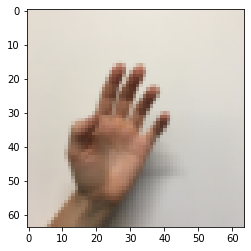

In [6]:
nth_img = 15
print('actual_label: '  + str(Y_train[nth_img]))
imshow(X_train[nth_img])

# Defining the architecture of the ResNet

![alt text](https://drive.google.com/u/0/uc?id=1i9zEzdzjLsI-QvV5NFIDTsNhfs-sHxbS)

## Identity Block

![alt text](https://miro.medium.com/max/1400/1*BCbJZXwGDtEdytj9ag_YWw.png)

In [7]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in in above figure
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

## Convolution Block

![alt text](https://miro.medium.com/max/1400/1*sb_4xKI_bRoX6jmZcNTRWw.png)

In [8]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    ## Different from the Identity block
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [10]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)


### We will **compile** our model by defining loss, optimizer and metrics that we will use to train our network.
* loss: [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function)
* optimizer: [adam](https://keras.io/api/optimizers/adam/)
* metrics: [accuracy](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# model.summary()

### Now, let's **train our model** by using the parameters that we defined before.

In [13]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
34/34 [==============================] - 39s 83ms/step - loss: 2.6205 - accuracy: 0.4083
Epoch 2/2
34/34 [==============================] - 2s 55ms/step - loss: 1.0572 - accuracy: 0.7287


### **Evaluation** of the trained model on validation data

In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 29ms/step - loss: 5.0250 - accuracy: 0.1667
Loss = 5.0250115394592285
Test Accuracy = 0.1666666716337204


## Pre-trained model

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')
# model.save('/content/drive/My Drive/Colab Notebooks/CNN Training/datasets/ResNet50.h5')

In [16]:
# !pip install gdown
import gdown
if 'ResNet50.h5' not in os.listdir('/content/'):
  gdown.download('https://drive.google.com/uc?id=14vW8s9Os7zXGeixXvMO9S1QoHBPM5MPx', '/content/ResNet50.h5', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14vW8s9Os7zXGeixXvMO9S1QoHBPM5MPx
To: /content/ResNet50.h5
284MB [00:02, 101MB/s]


In [17]:
model = load_model('/content/ResNet50.h5')

In [18]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 29ms/step - loss: 0.5506 - accuracy: 0.8833
Loss = 0.5505829453468323
Test Accuracy = 0.8833333253860474


## Let's visualize the correctly classified images

In [19]:
Y_pred = model.predict(X_test)

In [20]:
Y_pred_labels = np.argmax(Y_pred, axis = 1)
Y_test_labels = np.argmax(Y_test, axis = 1)

actual_label: 5
predicted_label: 5


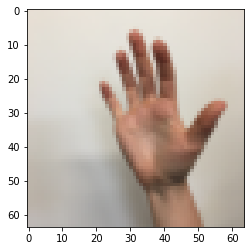

In [21]:
nth_img = 10
print('actual_label: '  + str(Y_test_labels[nth_img]))
print('predicted_label: '  + str(Y_pred_labels[nth_img]))
imshow(X_test[nth_img])

### How about we **visualize images that our model predicted incorrectly**.  
*   First we have to get the indexes of the images where y_pred and y_test doesn't match
*   Then we can visualize them one by one



In [22]:
np.where(Y_pred_labels != Y_test_labels)

(array([15, 17, 19, 21, 27, 37, 49, 50, 59, 71, 73, 75, 83, 86]),)

actual_label: 3
predicted_label: 5


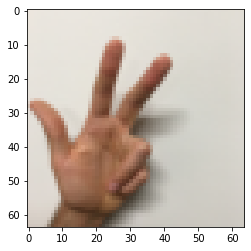

In [23]:
nth_img = 15
print('actual_label: '  + str(Y_test_labels[nth_img]))
print('predicted_label: '  + str(Y_pred_labels[nth_img]))
imshow(X_test[nth_img])